# Link Prediction Baselines
---
ROC AUC and Average Precision computed on Facebook dataset using these link prediction baselines:
1. Adamic-Adar
2. Jaccard Coefficient
3. Preferential Attachment

## 1. Read in Graph Data

In [10]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
EGO_USERs =[0,107,348,414,686,698,1684,1912,3437,3980]

for Ego in EGO_USERs:
    # Load pickled (adj, feat) tuple
    network_dir = f'./fb-processed/{Ego}-adj-feat.pkl'
    with open(network_dir, 'rb') as f:
        adj, features = pickle.load(f,encoding='latin1')
    g = nx.Graph(adj) 
    print(f'The size of the EGO {Ego} is {g.number_of_nodes()}')

The size of the EGO 0 is 348
The size of the EGO 107 is 1046
The size of the EGO 348 is 228
The size of the EGO 414 is 160
The size of the EGO 686 is 171
The size of the EGO 698 is 67
The size of the EGO 1684 is 793
The size of the EGO 1912 is 756
The size of the EGO 3437 is 548
The size of the EGO 3980 is 60


In [4]:
EGO_USER = 698 # which ego network to look at

# Load pickled (adj, feat) tuple
network_dir = f'./fb-processed/{EGO_USER}-adj-feat.pkl'
with open(network_dir, 'rb') as f:
    adj, features = pickle.load(f,encoding='latin1')
    


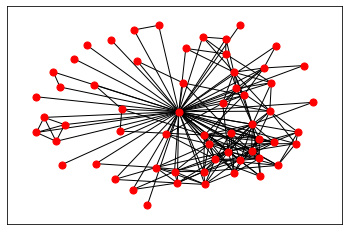

In [5]:
# draw network
nx.draw_networkx(g, with_labels=False, node_size=50, node_color='r')
plt.show()

## 2. Preprocessing/Train-Test Split

In [6]:
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def mask_test_edges(adj, test_frac=.01, prevent_disconnect=True):
    # NOTE: Splits are randomized and results might slightly deviate from reported numbers in the paper.
    # Remove diagonal elements
    #adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    #adj.eliminate_zeros()
    # Check that diag is zero:
    assert np.diag(adj.todense()).sum() == 0
    
    g = nx.from_scipy_sparse_array(adj)
    
    #orig_num_cc = nx.number_connected_components(g)
    adj_triu = sp.triu(adj,k=1) # upper triangular portion of adj matrix
    adj_tuple = sparse_to_tuple(adj_triu) # (coords, values, shape), edges only 1 way
    edges = adj_tuple[0] # all edges, listed only once (not 2 ways)
    # edges_all = sparse_to_tuple(adj)[0] # ALL edges (includes both ways)
    num_test = int(np.floor(edges.shape[0] * test_frac)) # controls how large the test set should be
    # Store edges in list of ordered tuples (node1, node2) where node1 < node2
    edge_tuples = [(min(edge[0], edge[1]), max(edge[0], edge[1])) for edge in edges]
    all_edge_tuples = set(edge_tuples)
    train_edges = set(edge_tuples) # initialize train_edges to have all edges
    test_edges = set()
    
    # Iterate over shuffled edges, add to train/val sets
    np.random.shuffle(edge_tuples)
    for edge in edge_tuples:
        # print edge
        if len(test_edges) == num_test :
            break
        node1 = edge[0]
        node2 = edge[1]  
        # If removing edge would disconnect a connected component, backtrack and move on
        g.remove_edge(node1, node2)
        if prevent_disconnect == True:
            if  nx.is_isolate(g,node1) or nx.is_isolate(g,node2) :
                g.add_edge(node1, node2)
                continue

        # Fill test_edges first
        if len(test_edges) < num_test:
            test_edges.add(edge)
            train_edges.remove(edge)
     # Both edge lists full --> break loop
    if (len(test_edges) < num_test):
        print ("WARNING: not enough removable edges to perform full train-test split!")
        print ("Num. (test, val) edges requested: :",num_test)
        print ("Num. (test, val) edges returned: (", len(test_edges), ")")

    
    test_edges_false = set()
    while len(test_edges_false) < num_test:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge not an actual edge, and not a repeat
        if false_edge in all_edge_tuples:
            continue
        if false_edge in test_edges_false:
            continue

        test_edges_false.add(false_edge)
    # assert: test, val, train positive edges disjoint
    assert test_edges.isdisjoint(train_edges)
    assert test_edges_false.isdisjoint(all_edge_tuples)
    # Re-build adj matrix using remaining graph
    adj_train = g
    
    # Convert edge-lists to numpy arrays
    train_edges = np.array([list(edge_tuple) for edge_tuple in train_edges])
    test_edges = np.array([list(edge_tuple) for edge_tuple in test_edges])
    test_edges_false = np.array([list(edge_tuple) for edge_tuple in test_edges_false])   
    # NOTE: these edge lists only contain single direction of edge!
    print('end split test')
    return adj_train, train_edges,test_edges,test_edges_false


In [7]:

np.random.seed(0) # make sure train-test split is consistent between notebooks
#adj_sparse = nx.to_scipy_sparse_array(g)

# Perform train-test split
g_train, train_edges,test_edges,test_edges_false = mask_test_edges(adj, test_frac=.1)

adj_train = nx.to_scipy_sparse_array(g_train) # new graph object with only non-hidden edges


end split test


In [8]:
# Inspect train/test split
print( "Total nodes:", adj_train.shape[0])
print( "Total edges:", int(adj_train.nnz/2)) # adj is symmetric, so nnz (num non-zero) = 2*num_edges)
print( "Training edges (positive):", len(train_edges))
#print( "Training edges (negative):", len(train_edges_false))
#print( "Validation edges (positive):", len(val_edges))
#print( "Validation edges (negative):", len(val_edges_false))
print( "Test edges (positive):", len(test_edges))
print( "Test edges (negative):", len(test_edges_false))

Total nodes: 67
Total edges: 303
Training edges (positive): 303
Test edges (positive): 33
Test edges (negative): 33


In [9]:
def get_roc_score(edges_pos, edges_neg, score_matrix):
    # Store positive edge predictions, actual values
    preds_pos = []
    pos = []
    for edge in edges_pos:
        preds_pos.append(score_matrix[edge[0], edge[1]]) # predicted score
        pos.append(adj_train[edge[0], edge[1]]) # actual value (1 for positive)
        
    # Store negative edge predictions, actual values
    preds_neg = []
    neg = []
    for edge in edges_neg:
        preds_neg.append(score_matrix[edge[0], edge[1]]) # predicted score
        neg.append(adj_train[edge[0], edge[1]]) # actual value (0 for negative)
        
    # Calculate scores
    preds_all = np.hstack([preds_pos, preds_neg])
    labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    return roc_score, ap_score



## 3. Adamic-Adar

In [11]:
# Compute Adamic-Adar indexes from g_train
aa_matrix = np.zeros(adj.shape)
for u, v, p in nx.adamic_adar_index(g_train): # (u, v) = node indices, p = Adamic-Adar index
    aa_matrix[u][v] = p
    aa_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
aa_matrix = aa_matrix / aa_matrix.max()

In [30]:
# Calculate ROC AUC and Average Precision
aa_roc, aa_ap = get_roc_score(test_edges, test_edges_false, aa_matrix)

print ('Adamic-Adar Test ROC score: ', (aa_roc))
print ('Adamic-Adar Test AP score: ', (aa_ap))
dic={'AA ROC': aa_roc,
     'AA AP' : aa_ap}


Adamic-Adar Test ROC score:  0.9485766758494032
Adamic-Adar Test AP score:  0.9221111094386449


## 4. Jaccard Coefficient

In [13]:
# Compute Jaccard Coefficients from g_train
jc_matrix = np.zeros(adj.shape)
for u, v, p in nx.jaccard_coefficient(g_train): # (u, v) = node indices, p = Jaccard coefficient
    jc_matrix[u][v] = p
    jc_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array

jc_matrix = jc_matrix / jc_matrix.max()

In [31]:
# Calculate ROC AUC and Average Precision
jc_roc, jc_ap = get_roc_score(test_edges, test_edges_false, jc_matrix)

print ('Jaccard Coefficient Test ROC score: ', str(jc_roc))
print ('Jaccard Coefficient Test AP score: ', str(jc_ap))

dic['JC ROC'] =jc_roc
dic[ 'JC AP'] = jc_ap




Jaccard Coefficient Test ROC score:  0.8861340679522497
Jaccard Coefficient Test AP score:  0.8545163965732141


## 5. Preferential Attachment

In [16]:
# Calculate, store Adamic-Index scores in array
pa_matrix = np.zeros(adj.shape)
for u, v, p in nx.preferential_attachment(g_train): # (u, v) = node indices, p = Jaccard coefficient
    pa_matrix[u][v] = p
    pa_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
pa_matrix = pa_matrix / pa_matrix.max()

In [32]:
# Calculate ROC AUC and Average Precision
pa_roc, pa_ap = get_roc_score(test_edges, test_edges_false, pa_matrix)

print ('Preferential Attachment Test ROC score: ', str(pa_roc))
print ('Preferential Attachment Test AP score: ', str(pa_ap))
dic['PA ROC'] =pa_roc
dic[ 'PA AP' ] = pa_ap

Preferential Attachment Test ROC score:  0.7516069788797062
Preferential Attachment Test AP score:  0.7787389477395283


In [33]:
results =pd.DataFrame(dic,index=[0])
results

,AA ROC,AA AP,JC ROC,JC AP,PA ROC,PA AP
0,0.948577,0.922111,0.886134,0.854516,0.751607,0.778739


In [114]:
def Get_baseline_Performance():
    # Read a networks 
    AA_roc=[]
    AA_ap=[]
    JC_roc=[]
    JC_ap=[]
    PA_roc=[]
    PA_ap=[]
    EGO_USERs =[0,107,348,414,686,698,1684,1912,3437,3980]

    for Ego in EGO_USERs:
        # Load pickled (adj, feat) tuple
        network_dir = f'./fb-processed/{Ego}-adj-feat.pkl'
        with open(network_dir, 'rb') as f:
            adj, features = pickle.load(f,encoding='latin1')
        
        g = nx.Graph(adj) 
        print(f'The size of the EGO {Ego} is {g.number_of_nodes()}')

        #Spliting data
        g_train, train_edges,test_edges,test_edges_false = mask_test_edges(adj, test_frac=.3)
        adj_train = nx.to_scipy_sparse_array(g_train) # new graph object with only non-hidden edges 

        aa_matrix = np.zeros(adj_train.shape)
        for u, v, p in nx.adamic_adar_index(g_train): # (u, v) = node indices, p = Adamic-Adar index
            aa_matrix[u][v] = p
            aa_matrix[v][u] = p # make sure it's symmetric
            
        # Normalize array
        aa_matrix = aa_matrix / aa_matrix.max()
        # Calculate ROC AUC and Average Precision
        aa_roc, aa_ap = get_roc_score(test_edges, test_edges_false, aa_matrix)
        AA_roc.append(aa_roc)
        AA_ap.append(aa_ap)

        jc_matrix = np.zeros(adj.shape)
        for u, v, p in nx.jaccard_coefficient(g_train): # (u, v) = node indices, p = Jaccard coefficient
            jc_matrix[u][v] = p
            jc_matrix[v][u] = p # make sure it's symmetric
            
        # Normalize array
        jc_matrix = jc_matrix / jc_matrix.max()

        # Calculate ROC AUC and Average Precision
        jc_roc, jc_ap = get_roc_score(test_edges, test_edges_false, jc_matrix)
        JC_roc.append(jc_roc)
        JC_ap.append(jc_ap)


        # Calculate, store Adamic-Index scores in array
        pa_matrix = np.zeros(adj.shape)
        for u, v, p in nx.preferential_attachment(g_train): # (u, v) = node indices, p = Jaccard coefficient
            pa_matrix[u][v] = p
            pa_matrix[v][u] = p # make sure it's symmetric
            
        # Normalize array
        pa_matrix = pa_matrix / pa_matrix.max()

        # Calculate ROC AUC and Average Precision
        pa_roc, pa_ap = get_roc_score(test_edges, test_edges_false, pa_matrix)
        PA_roc.append(pa_roc)
        PA_ap.append(pa_ap)
        
    return AA_roc, AA_ap, JC_roc, JC_ap, PA_roc, PA_ap

In [116]:
AA_roc, AA_ap, JC_roc, JC_ap, PA_roc, PA_ap = Get_baseline_Performance()


The size of the EGO 0 is 348
end split test
The size of the EGO 107 is 1046
end split test
The size of the EGO 348 is 228
end split test
The size of the EGO 414 is 160
end split test
The size of the EGO 686 is 171
end split test
The size of the EGO 698 is 67
end split test
The size of the EGO 1684 is 793
end split test
The size of the EGO 1912 is 756
end split test
The size of the EGO 3437 is 548
end split test
The size of the EGO 3980 is 60
end split test


In [120]:
JC_roc

[0.8151883569301824,
 0.9513370138052505,
 0.8870424747174301,
 0.919125071016963,
 0.8585186274477038,
 0.8359000000000001,
 0.9190255462314908,
 0.9722609242926985,
 0.8672350699858915,
 0.5783391561408223]

In [133]:
dic={

    'AA_roc':AA_roc,
    'AA_ap':AA_ap,
    'JC_roc':JC_roc,
    'JC_ap':JC_ap,
    'PA_roc':PA_roc,
    'PA_ap':PA_ap

}
results =pd.DataFrame(dic,index=EGO_USERs)
results

,AA_roc,AA_ap,JC_roc,JC_ap,PA_roc,PA_ap
0,0.946062,0.947378,0.815188,0.777932,0.863491,0.878723
107,0.966778,0.963453,0.951337,0.946750,0.823322,0.844957
348,0.920618,0.909665,0.887042,0.869609,0.831999,0.838378
414,0.964862,0.958505,0.919125,0.886145,0.797305,0.803222
686,0.915482,0.907259,0.858519,0.850766,0.819273,0.839546
698,0.936400,0.943129,0.835900,0.799931,0.783100,0.832221
1684,0.951211,0.949437,0.919026,0.917088,0.806058,0.817059
1912,0.977119,0.975191,0.972261,0.968810,0.847963,0.863997
3437,0.947340,0.949480,0.867235,0.869677,0.790915,0.805279
3980,0.872077,0.903389,0.578339,0.533217,0.863746,0.886471


In [134]:
print(results['AA_roc'].mean(),results['JC_roc'].mean(),results['PA_roc'].mean())

0.939794816628357 0.8603972240568434 0.822717239521757


In [135]:
import seaborn as sns

<AxesSubplot:>

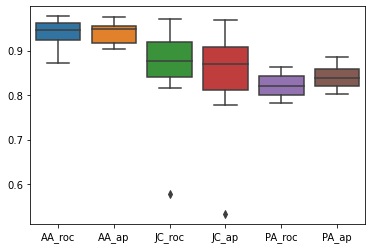

In [138]:
sns.boxplot(data=results)